## **Imports**

In [1]:
""" Import Statements """

# Classics
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import re
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('../data/cannabis.csv')

#change from combined_cannabis.csv to cannabis.csv

In [3]:
print('Shape:', df.shape)
df.head()

Shape: (2155, 8)


,Index,Strain,Type,Rating,Effects,Description,Flavors,Nearest
0,0,Kelly Hill Gold,indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","0,992,1671,1419,897,184"
1,1,Spyder Mon,hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","1,964,1627,80,157,693"
2,2,Mochi,hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","2,614,457,208,1545,705"
3,3,Molokai Purpz,indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka’i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","3,276,1478,2093,2079,562"
4,4,Monolith,indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","4,1397,862,1094,141,1405"


## **Data Cleaning**

In [4]:
df.isnull().sum()

Index          0
Strain         0
Type           0
Rating         0
Effects        0
Description    0
Flavors        0
Nearest        0
dtype: int64

## **Tokenizing**

### Creating a corpus

In [5]:
#Combining features to create a strain profile
df['strain_profile'] = df['Type'] + ',' + df['Effects'] + ',' + df['Description']

In [6]:
#Doing some manual cleaning 

#Lowercase text
df['strain_profile'] = df['strain_profile'].apply(lambda x: x.lower())

#Remove symbols
df['strain_profile'] = df['strain_profile'].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ', x))

In [7]:
df.head()

,Index,Strain,Type,Rating,Effects,Description,Flavors,Nearest,strain_profile
0,0,Kelly Hill Gold,indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","0,992,1671,1419,897,184",indica happy energetic euphoric talkative arou...
1,1,Spyder Mon,hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","1,964,1627,80,157,693",hybrid uplifted creative focused happy relaxed...
2,2,Mochi,hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","2,614,457,208,1545,705",hybrid sleepy happy hungry relaxed tingly moch...
3,3,Molokai Purpz,indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka’i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","3,276,1478,2093,2079,562",indica aroused creative euphoric relaxed sleep...
4,4,Monolith,indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","4,1397,862,1094,141,1405",indica relaxed sleepy tingly euphoric focused ...


### spaCy s

In [8]:
nlp = spacy.load("en_core_web_lg")

In [9]:
STOP_WORDS = nlp.Defaults.stop_words.union({"$", 'strain','', "flower", None, '-', ' ',"it's", 'i', "i'm", "i've", "it's", "don't", 'got', 'it.',  'weed', 'effects', 'effect', 'high', 'consumer', 'breed', 'unkown', 'unavailable', 's'})

In [10]:
def tokenize(text):
  doc = nlp(text) #casting as text
  return [token.lemma_.strip() for token in doc if not token.is_stop and not token.is_punct]

In [11]:
df['tokens'] = df['strain_profile'].apply(tokenize)

In [12]:
df['tokens']

0       [indica, happy, energetic, euphoric, talkative...
1       [hybrid, uplifted, creative, focus, happy, rel...
2       [hybrid, sleepy, happy, hungry, relaxed, tingl...
3       [indica, arouse, creative, euphoric, relaxed, ...
4       [indica, relax, sleepy, tingly, euphoric, focu...
                              ...                        
2150    [indica, uplifted, focus, sleepy, relaxed, tin...
2151    [hybrid, happy, white, strawberry, flavorful, ...
2152    [hybrid, talkative, happy, energetic, tingly, ...
2153    [hybrid, relax, focus, uplifted, creative, hap...
2154    [sativa, giggly, uplifted, creative, happy, sl...
Name: tokens, Length: 2155, dtype: object

In [13]:
# Gut check

# Object from Base Python

word_counts = Counter()

# Update it based on a split of each of our documents
df["tokens"].apply(lambda x: word_counts.update(x))

# Print out the 20 most common words
word_counts.most_common(20)

[('', 16203),
 ('strain', 2759),
 ('hybrid', 2331),
 ('indica', 2003),
 ('happy', 1922),
 ('euphoric', 1745),
 ('effect', 1475),
 ('sativa', 1469),
 ('uplifted', 1358),
 ('s', 1271),
 ('relaxed', 1163),
 ('cross', 1031),
 ('og', 993),
 ('kush', 987),
 ('aroma', 919),
 ('dominant', 892),
 ('relax', 875),
 ('creative', 843),
 ('sweet', 787),
 ('bud', 737)]

In [14]:
def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [15]:
wc = count(df["tokens"])
wc.head(50)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,,2133,16203,1.0,0.123908,0.123908,0.989791
1,strain,1694,2759,2.0,0.021099,0.145007,0.786079
89,hybrid,1309,2331,3.0,0.017826,0.162833,0.607425
5,indica,1088,2003,4.0,0.015317,0.178150,0.504872
26,happy,1821,1922,5.0,0.014698,0.192848,0.845012
19,euphoric,1609,1745,6.0,0.013344,0.206193,0.746636
36,effect,1217,1475,7.0,0.011280,0.217472,0.564733
268,sativa,838,1469,8.0,0.011234,0.228706,0.388863
70,uplifted,1342,1358,9.0,0.010385,0.239091,0.622738
75,s,895,1271,10.0,0.009720,0.248811,0.415313


### Visualize tokens

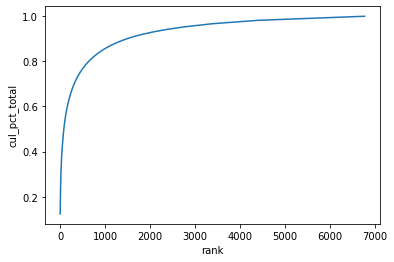

In [16]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [17]:
# Percentage of the the top 200 words

wc[wc['rank'] <= 200]['cul_pct_total'].max()

0.6341327256320445

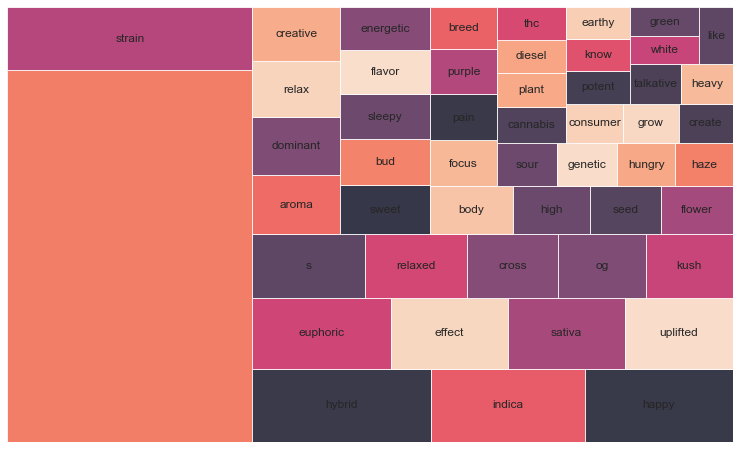

In [18]:
sns.set(rc={'figure.figsize':(13,8)})

wc_top20 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

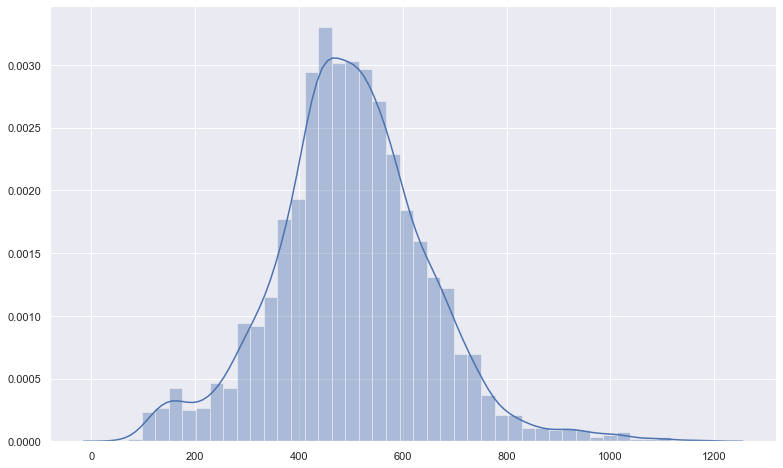

In [20]:
# Visualize document length distribution of Description data set

doc_len = [len(doc) for doc in df['strain_profile']]

sns.distplot(doc_len);

In [21]:
df = df.drop(['strain_profile', 'tokens'], axis=1)

In [22]:
df.head()

,Index,Strain,Type,Rating,Effects,Description,Flavors,Nearest
0,0,Kelly Hill Gold,indica,5.0,"Happy,Energetic,Euphoric,Talkative,Aroused",Cultivated by Joseph Arthur Botanicals in Colo...,"Pepper,Earthy,Coffee","0,992,1671,1419,897,184"
1,1,Spyder Mon,hybrid,5.0,"Uplifted,Creative,Focused,Happy,Relaxed",Spyder Mon is an uplifting CBD strain with a g...,"Citrus,Earthy,Sweet","1,964,1627,80,157,693"
2,2,Mochi,hybrid,5.0,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...,"Pungent,Minty,Flowery","2,614,457,208,1545,705"
3,3,Molokai Purpz,indica,5.0,"Aroused,Creative,Euphoric,Relaxed,Sleepy",Moloka’i Purpz is a luscious Hawaiian landrace...,"Berry,Grape,Sweet","3,276,1478,2093,2079,562"
4,4,Monolith,indica,5.0,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...,"Pungent,Earthy,Pine","4,1397,862,1094,141,1405"


# ML Model

## Vectorization

### TFIDF

In [19]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,3),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize,
                        max_features = 5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['Type'] + df['Description'] + df['Effects'] + df['Flavors']) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,1,10,10 11,10 11 week,10 week,10 week flower,10 week produce,100,11,11 week,...,yield high,yield plant,yield potency,yield thc,yields.happy,yoda,zest,zesty,zesty lemon,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Nearest Neighbors model

In [23]:
nn = NearestNeighbors(n_neighbors=5, algorithm = "kd_tree")
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [24]:
user_input = ['I am suffering from headaches. Looking for a sweet flavor and being uplifted and energetic.']

In [25]:
user_dense = tfidf.transform(user_input)
nn_user = nn.kneighbors(user_dense.todense())

In [26]:
nn_user

(array([[1.29558101, 1.29818936, 1.30351785, 1.31312235, 1.31513437]]),
 array([[1846, 1354,  596, 1266, 1312]]))

In [28]:
df.iloc[1846]

Index                                                       1846
Strain                                                 Fire Haze
Type                                                      sativa
Rating                                                      3.18
Effects                  Euphoric,Focused,Happy,Relaxed,Uplifted
Description    Fire Haze is a true sativa. Great for consumer...
Flavors                                       Sweet,Berry,Earthy
Nearest                            1846,1775,1137,1052,1937,1406
Name: 1846, dtype: object

In [29]:
df.iloc[1354]

Index                                                       1354
Strain                                                Lemon Jack
Type                                                      sativa
Rating                                                      3.64
Effects                Focused,Energetic,Happy,Uplifted,Creative
Description    While Lemon Jack has yet to earn the reputatio...
Flavors                                       Lemon,Citrus,Sweet
Nearest                              1354,1895,425,1366,824,1707
Name: 1354, dtype: object

In [30]:
df.iloc[596]

Index                                                        596
Strain                                                 Glue Tech
Type                                                      hybrid
Rating                                                      4.09
Effects                   Happy,Relaxed,Hungry,Uplifted,Euphoric
Description    Glue Tech is a functional indica that shows it...
Flavors                                       Earthy,Sweet,Berry
Nearest                                 596,354,205,161,2100,420
Name: 596, dtype: object

In [31]:
df.iloc[1266]

Index                                                       1266
Strain                                         Cinderellas Dream
Type                                                      hybrid
Rating                                                      3.64
Effects             Euphoric,Uplifted,Energetic,Focused,Creative
Description    Cinderella’s Dream is a sativa-dominant hybrid...
Flavors                                      Pepper,Sweet,Citrus
Nearest                             1266,1345,634,1133,1406,1287
Name: 1266, dtype: object

In [32]:
df.iloc[1312]

Index                                                       1312
Strain                                         Super Silver Haze
Type                                                      sativa
Rating                                                      3.64
Effects                Happy,Uplifted,Energetic,Euphoric,Relaxed
Description    Super Silver Haze, bred by Green House Seeds, ...
Flavors                                      Citrus,Earthy,Sweet
Nearest                             1312,1813,1874,1271,689,1878
Name: 1312, dtype: object

# Functions

In [37]:
# Create recommender function

import json

def recommender(user_input):
    
    recommendations = nn.kneighbors(tfidf.transform(user_input).todense())[1]
    
    for i in range(5):
        info = df.loc[recommendations[0][i]]
        
        return dict(info)

#Does not print all 5 results? 

In [38]:
recommender(user_input)

{'Index': 1846,
 'Strain': 'Fire Haze',
 'Type': 'sativa',
 'Rating': 3.18,
 'Effects': 'Euphoric,Focused,Happy,Relaxed,Uplifted',
 'Description': 'Fire Haze is a true sativa. Great for consumers who suffer from stress, anxiety, and headaches, this strain is mentally stimulating and upbeat. The effects of Fire Haze are felt most strongly in the head, providing consumers with focus and tension reduction in both the head and neck. Sociable and energizing, Fire Haze is a great daytime strain. It features a strong herbal scent and a musky, nutty taste. This may not be a good strain for those who suffer from acute pain, as it does not provide the same muscle-relaxing sensations that are found in indicas.',
 'Flavors': 'Sweet,Berry,Earthy',
 'Nearest': '1846,1775,1137,1052,1937,1406'}